In [2]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt


from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

$$ n =\frac{\rho}{m_n} = \frac{2p_F^3}{3\pi^2\hbar^3} \iff x_F = \frac{p_F}{m_n c}\iff \frac{\rho}{m_n} =\frac{2}{3\pi^2} \left(\frac{ m_n c}{\hbar}\right)^3x_F^3 $$ 
$$ 1-x_\sigma - A_\sigma^2 \frac{2}{\pi^2 } \int_0^{x_F(n)} \frac{ x_\sigma}{\sqrt{x^2 + x_\sigma^2}} x^2 dx = 0$$
con
$$x_\sigma= 1- \frac{g_\sigma \sigma}{m_n} \qquad ; \quad A_\sigma=\frac{g_\sigma m_n}{m_\sigma}$$

In [1]:
#hbar_MKS = 1.0545718e-34 # J s
#c_MKS = 299792458 # m/s
#G_MKS = 6.67430e-11 # m^3/kg/s^2
#pi = np.pi
#m_nuc_MKS = 1.6726219e-27 # kg

c    = 2.99792458e10
G    = 6.67e-8
mn   = 1.674e-24
hbar = 1.05457162e-27
fm   = 1e-13

mn_a = mn*c/hbar
# Definimos las constantes necesarias en unidades geometrizadas
#hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
#m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes (valores tomados del paper de Walecka)
#A_sigma = np.sqrt(266.9*hbar/m_nuc**2)
#A_omega = np.sqrt(195.7*hbar/m_nuc**2)


def autoconsistencia(x_s, A_s, rho_):
    n_ = rho_ / mn
    x_f = (1.0/mn_a)*(3.0*np.pi**2*n_/2.0)**(1/3) # Momento de Fermi en función de n_barion
    # La integral es analítica
    integral = x_s * ( x_f * np.sqrt( x_s**2 + x_f**2 ) - x_s**2 * np.arctanh( x_f/np.sqrt(x_s**2+x_f**2) ) )
    return 1.0 - x_s - A_s * integral / ( 3.0 * np.pi**2 )

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def solucion_x_sigma(rho_b, A_sigma):
    return fsolve(autoconsistencia, 1, args=(A_sigma, rho_b))[0]

In [3]:
xx = np.arange(10,17,0.1)
xxs = np.zeros(len(xx))

for i,x in enumerate(xx):
    xxs[i] = solucion_x_sigma(np.power(10.0,x), 266.9)

In [6]:
len(xx)

70

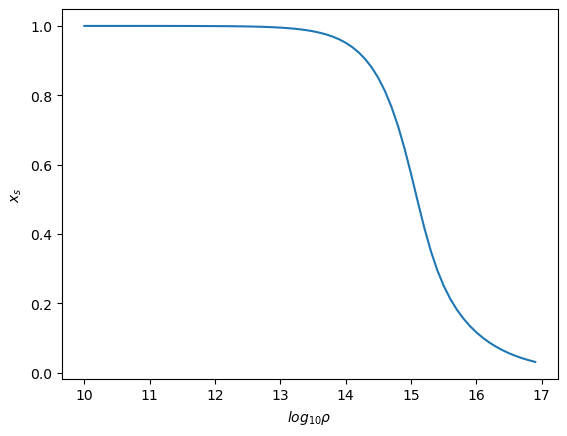

In [4]:
plt.plot(xx, xxs)
plt.xlabel(r'$log_{10} \rho$')
plt.ylabel(r'$x_s$')
plt.show()

In [5]:
xxs

array([0.99999507, 0.99999379, 0.99999218, 0.99999016, 0.99998761,
       0.99998441, 0.99998037, 0.99997529, 0.99996889, 0.99996083,
       0.99995069, 0.99993793, 0.99992186, 0.99990162, 0.99987616,
       0.9998441 , 0.99980374, 0.99975293, 0.99968898, 0.99960847,
       0.99950714, 0.99937958, 0.99921903, 0.99901694, 0.99876258,
       0.99844245, 0.99803957, 0.99753255, 0.99689452, 0.99609171,
       0.99508162, 0.99381088, 0.99221243, 0.99020204, 0.987674  ,
       0.9844957 , 0.98050093, 0.97548155, 0.96917732, 0.96126338,
       0.95133532, 0.93889143, 0.92331267, 0.90384144, 0.8795627 ,
       0.84939551, 0.81211383, 0.76643674, 0.71127178, 0.64625717,
       0.57273992, 0.49486864, 0.41927846, 0.35207744, 0.29585258,
       0.24997705, 0.21257172, 0.1817653 , 0.15607457, 0.13440466,
       0.11595841, 0.10014901, 0.08653487, 0.07477467, 0.0645973 ,
       0.05578186, 0.04814439, 0.04152901, 0.03580192, 0.03084728])